In [2]:
import mujoco
from anytree import Node, RenderTree

In [3]:
model = mujoco.MjModel.from_xml_path('../assets/mujoco_menagerie/unitree_a1/a1.xml')

## Build a body tree

In [4]:
bodies = []

# Name's not present here, extracting manually
def extract_name(names):
    return names.decode("utf-8").split('\0')[0]

for i in range(0, model.nbody):
    bodies.append({
        'mj_body': model.body(i), 
        'name': extract_name(model.names[model.name_bodyadr[i]:]),
        'id': i,
        'geom': None,
        }
    )
    

In [5]:
mj_bodies = []

def fill_children(node):
    for b in bodies:
        if (b['mj_body'].parentid == node.data['id']) and (b['mj_body'].parentid != b['id']):
            fill_children(Node(b['name'], data=b, parent=node))
    return node

for body in filter(lambda x: x['mj_body'].parentid == 0, bodies):
    mj_bodies.append(fill_children(Node(body['name'], data=body)))


Here's how body tree looks like

In [6]:
for pre, fill, node in RenderTree(mj_bodies[1]):
    print("%s%s" % (pre, node.name))

trunk
├── FR_hip
│   └── FR_thigh
│       └── FR_calf
├── FL_hip
│   └── FL_thigh
│       └── FL_calf
├── RR_hip
│   └── RR_thigh
│       └── RR_calf
└── RL_hip
    └── RL_thigh
        └── RL_calf


## Find render bodies

In [7]:
meshes = []

for i in range(0, model.nmesh):
    meshes.append({
        'mj_mesh': model.mesh(i),
        'name': extract_name(model.names[model.name_meshadr[i]:]),
        'id': i,
        }
    )

In [8]:
geoms = []

for i in range(0, model.ngeom):

    geom = model.geom(i)
    mesh_id = geom.dataid[0]

    geoms.append({
        'mj_geom': geom,
        'id': i,
        'mesh': meshes[mesh_id] if mesh_id >= 0 else None
        }
    )


So render bodies are found by iterating over all bodies and checking if they group id in 0, 1, 2. Is there a better way?

In [9]:
def fill_geoms(node):
    filtered_geoms = list(filter(lambda x: x['mj_geom'].bodyid == node.data['id'] and x['mj_geom'].group[0] in (0, 1, 2), geoms))
    geom = sorted(filtered_geoms, key=lambda x: x['mj_geom'].group, reverse=True)[0]
    node.data['geom'] = geom
    for child in node.children:
        fill_geoms(child)

fill_geoms(mj_bodies[1])

In [10]:
meshes = []

for i in range(0, model.nmesh):
    meshes.append({
        'mj_mesh': model.geom(i),
        'name': extract_name(model.names[model.name_geomadr[i]:]),
        'id': i,
        }
    )

## Let's render

In [11]:
from vedo import *
import numpy as np
import quaternion

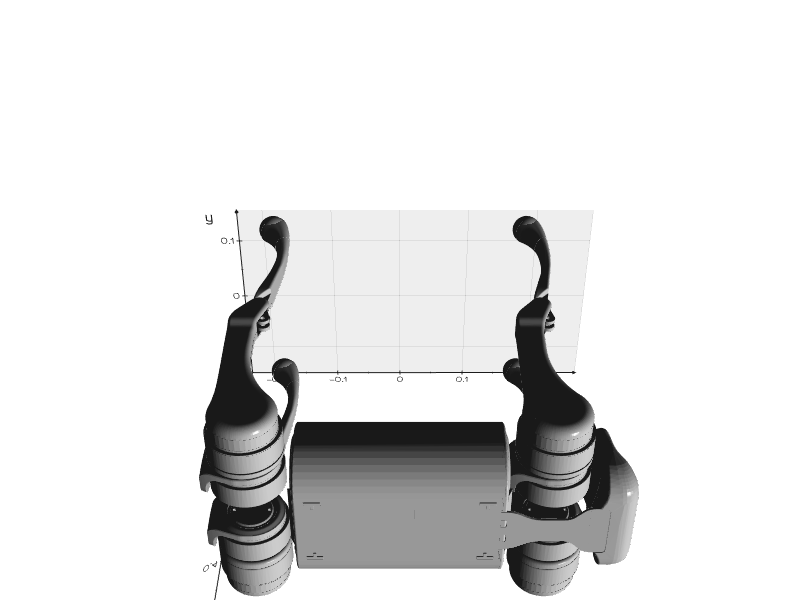

In [134]:
MODEL_DIR = "../assets/mujoco_menagerie/unitree_a1/assets/"

p1 = Point([1, 0, 1], c="white")
l1 = Light(p1, c="white")

meshes_to_render = []

def parent_offset(node):
    if node.parent is None:
        return np.array([0, 0, 0])
    return np.array(node.parent.data['mj_body'].pos) + parent_offset(node.parent)

def parent_rotation(node):
    if node.parent is None:
        return np.quaternion(1, 0, 0, 0)
    quat = node.parent.data['mj_body'].quat
    return parent_rotation(node.parent) * np.quaternion(quat[0], quat[1], quat[2], quat[3])

def render_body(body, depth):
    geom_path = MODEL_DIR + body.data['geom']['mesh']['name'] + '.obj'
    mesh = Mesh(geom_path)
    mesh.c("white").lighting("glossy")

    mj_geom = body.data['geom']['mj_geom']
    mj_body = body.data['mj_body']

    body_quat = np.quaternion(mj_body.quat[0], mj_body.quat[1], mj_body.quat[2], mj_body.quat[3])
    geom_quat = np.quaternion(mj_geom.quat[0], mj_geom.quat[1], mj_geom.quat[2], mj_geom.quat[3])
    parent_quat = parent_rotation(body)

    quat = parent_quat * body_quat + geom_quat

    if depth > 0:
        mesh.rotate(quat)

    # IGNORE ROTATIONS FOR NOW

    # euler = quaternion.as_euler_angles(quat)
    # mesh.rotate_y(euler[0], rad=True)
    # mesh.rotate_x(euler[1], rad=True)    
    # mesh.rotate_z(euler[2], rad=True)

    # mj_geom.pos correction introduces a bug

    offset = parent_offset(body) + np.array(mj_body.pos)# + np.array(mj_geom.pos)
    mesh.pos(offset)
    
    meshes_to_render.append(mesh)


def render_part(body, depth):
    depth = 0
    render_body(body, depth)
    for child in body.children:
        render_part(child, depth+1)

render_part(mj_bodies[1], 0)

show(meshes_to_render, l1, camera={'pos':(0.0,1.0,1.4)}, axes=True)